<a href="https://colab.research.google.com/github/Dav-web/MSC.-Thesis/blob/main/Topic_Bert_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modeling with deep learning (TopicBert)

In [1]:
# mount the google drive to read in data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# define file path on google drive
root_path = '/content/gdrive/My Drive/covidvaccine.csv'

## Import Libraries and Helper Functions

In [3]:
!pip install numpy

In [4]:
!pip install pyLDAvis

In [ ]:
!pip install pyLDAvis --upgrade

In [5]:
!pip install plotly

In [6]:
%%capture
!pip install sentence_transformers
!pip install bertopic[visualization]
from bertopic import BERTopic

In [7]:
!pip install umap-learn
!pip install pynndescent
!pip install llvmpy
!pip install cython
!pip install numba

  Using cached llvmpy-0.12.7.tar.gz (657 kB)
  Using cached llvmpy-0.12.6.tar.gz (654 kB)
  Using cached llvmpy-0.12.5.tar.gz (659 kB)
  Using cached llvmpy-0.12.4.tar.gz (651 kB)
  Using cached llvmpy-0.11.2.tar.gz (642 kB)
  Using cached llvmpy-0.11.0.tar.gz (637 kB)
  Using cached llvmpy-0.10.2.tar.gz (555 kB)
  Using cached llvmpy-0.10.1.tar.gz (546 kB)
  Using cached llvmpy-0.10.0.tar.gz (540 kB)
  Using cached llvmpy-0.9.tar.gz (414 kB)
  Using cached llvmpy-0.8.2.tar.gz (486 kB)
ERROR: Could not find a version that satisfies the requirement llvmpy (from versions: 0.12.7-9-g60b512d, 0.8.2, 0.9, 0.10.0, 0.10.1, 0.10.2, 0.11.0, 0.11.2, 0.12.4, 0.12.5, 0.12.6, 0.12.7)
ERROR: No matching distribution found for llvmpy


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.cluster import k_means
import re
import numpy as np 
import pandas as pd
import sys
import json
from bertopic import BERTopic
import pyLDAvis
import copy
import math
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [9]:
from sentence_transformers import *
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
from datetime import datetime
from nltk.stem import WordNetLemmatizer
import nltk
!pip install emoji
import emoji
import nltk
nltk.download('words')
nltk.download('stopwords')
words = set(nltk.corpus.words.words())
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import matplotlib.cm as cm
import torch
import sentence_transformers
import umap
import plotly
#plotly.offline.init_notebook_mode (connected = True)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Read in Data from the Data Source (Google drive)

In [178]:
df = pd.read_csv(root_path)
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,MyNewsNE,Assam,MyNewsNE a dedicated multi-lingual media house from North Eastern India.,24-05-2020 10:18,64.0,11.0,110.0,False,18-08-2020 12:55,Australia to Manufacture Covid-19 Vaccine and give it to the Citizens for free of cost: AFP quotes Prime Minister\n#CovidVaccine,['CovidVaccine'],Twitter Web App,False
1,Shubham Gupta,NaN,I will tell about all experiences of my life from my videos hope that you all like the videos 🙂,14-08-2020 16:42,1.0,17.0,0.0,False,18-08-2020 12:55,#CoronavirusVaccine #CoronaVaccine #CovidVaccine Australia is doing very good https://t.co/kBT7l6pArY,"['CoronavirusVaccine', 'CoronaVaccine', 'CovidVaccine']",Twitter for Android,False
2,Journal of Infectiology,NaN,Journal of Infectiology (ISSN 2689-9981) is accepting submissions for an upcoming Volume 3 Issue 2. For further queries contact editor@infectiologyjournal.com.,14-12-2017 07:07,143.0,566.0,8.0,False,18-08-2020 12:46,Deaths due to COVID-19 in Affected Countries\nRead More: https://t.co/V8Y3Stu0UW\n@r_piryani @shitalbhandary… https://t.co/6jpMxX2KtI,NaN,Twitter Web App,False
3,Zane,NaN,Fresher than you.,18-09-2019 11:01,29.0,25.0,620.0,False,18-08-2020 12:45,@Team_Subhashree @subhashreesotwe @iamrajchoco Stay safe @subhashreesotwe di &amp; @iamrajchoco da ❤️❤️… https://t.co/ayhoaQm0Ls,NaN,Twitter for Android,False
4,Ann-Maree O’Connor,"Adelaide, South Australia","Retired university administrator. Melburnian by birth, now living in Adelaide. Look back fondly to the Whitlam years; one of Keating’s true believers.",24-01-2013 14:53,83.0,497.0,10737.0,False,18-08-2020 12:45,@michellegrattan @ConversationEDU This is what passes for leadership in our country: a voucher for something that w… https://t.co/OUUb1PeYIj,NaN,Twitter Web App,False


## Data Cleaning and Preprocessing

In [11]:
import pandas as pd
import re
import gensim
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'RT', 'amp', 'afp'])

punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'         # define a string of punctuation symbols

# Functions to clean tweets
def remove_links(tweet):
    """Takes a string and removes web links from it"""
    tweet = re.sub(r'http\S+', '', tweet)   # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  # remove bitly links
    tweet = tweet.strip('[link]')   # remove [links]
    tweet = re.sub(r'pic.twitter\S+','', tweet)
    return tweet

def remove_users(tweet):
    """Takes a string and removes retweet and @user information"""
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', str(tweet))  # remove re-tweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', str(tweet))  # remove tweeted at
    return tweet

def remove_hashtags(tweet):
    """Takes a string and removes any hash tags"""
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove hash tags
    return tweet

def remove_av(tweet):
    """Takes a string and removes AUDIO/VIDEO tags or labels"""
    tweet = re.sub('VIDEO:', '', tweet)  # remove 'VIDEO:' from start of tweet
    tweet = re.sub('AUDIO:', '', tweet)  # remove 'AUDIO:' from start of tweet
    return tweet

def tokenize(tweet):
    """Returns tokenized representation of words in lemma form excluding stopwords"""
    result = []
    for token in gensim.utils.simple_preprocess(tweet, deacc=True, min_len=3):  # drops words with less than 3 characters
            result.append(lemmatize(token))
    return result

def lemmatize(token):
    """Returns lemmatization of a token"""
    return WordNetLemmatizer().lemmatize(token, pos='v')

def preprocess_tweet(tweet):
    """Main master function to clean tweets, stripping noisy characters, and tokenizing use lemmatization"""
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_av(tweet)
    tweet = tweet.lower()  # lower case
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    tweet_token_list = tokenize(tweet)  # apply lemmatization and tokenization
    tweet = ' '.join(tweet_token_list)
    return tweet

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
df['tweet'] = df['text'].map(lambda x: preprocess_tweet(x))

In [13]:
pd.set_option('display.max_colwidth', 400)
df[['tweet', 'text']].head()

,tweet,text
0,australia manufacture covid vaccine and give the citizens for free cost afp quote prime minister,Australia to Manufacture Covid-19 Vaccine and give it to the Citizens for free of cost: AFP quotes Prime Minister\n#CovidVaccine
1,australia do very good,#CoronavirusVaccine #CoronaVaccine #CovidVaccine Australia is doing very good https://t.co/kBT7l6pArY
2,deaths due covid affect countries read more,Deaths due to COVID-19 in Affected Countries\nRead More: https://t.co/V8Y3Stu0UW\n@r_piryani @shitalbhandary… https://t.co/6jpMxX2KtI
3,stay safe amp,@Team_Subhashree @subhashreesotwe @iamrajchoco Stay safe @subhashreesotwe di &amp; @iamrajchoco da ❤️❤️… https://t.co/ayhoaQm0Ls
4,this what pass for leadership our country voucher for something that,@michellegrattan @ConversationEDU This is what passes for leadership in our country: a voucher for something that w… https://t.co/OUUb1PeYIj


## Encode Tweets Using Sentence Transformer

In [14]:
# Convert to list
data = df['tweet'].values.tolist()
print(data[:1])

['australia manufacture covid vaccine and give the citizens for free cost afp quote prime minister']


In [16]:
# Load sentence transformer model
sentence_model = SentenceTransformer("all-roberta-large-v1")

# Create documents embeddings
embeddings = sentence_model.encode(data, show_progress_bar=True)

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.84k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/650 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/328 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/191 [00:00<?, ?B/s]

Batches:   0%|          | 0/11519 [00:00<?, ?it/s]

In [17]:
embeddings.shape

(368588, 1024)

## Baseline Clustering Model

In [15]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 1)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, 
                                   init_size=256, 
                                   batch_size=512, 
                                   random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters
Fit 16 clusters
Fit 17 clusters
Fit 18 clusters
Fit 19 clusters
Fit 20 clusters


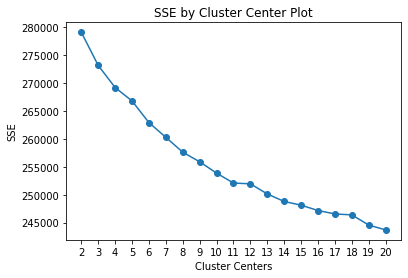

In [18]:
find_optimal_clusters(embeddings, 20)

In [19]:
clusters_5 = MiniBatchKMeans(n_clusters=5, init_size=1024, batch_size=2048, random_state=20).fit_predict(embeddings)

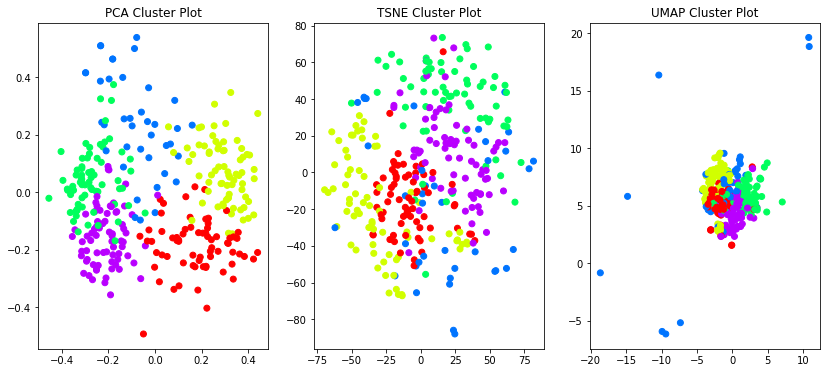

In [21]:
def plot_tsne_pca_umap(data, labels):
    max_label = max(labels)+1
    max_items = np.random.choice(range(data.shape[0]), size=10000, replace=False)
    
    reducer=umap.UMAP()
    pca = PCA(n_components=2).fit_transform(data[max_items,:])
    tsne = TSNE().fit_transform(PCA(n_components=500).fit_transform(data[max_items,:]))
    uma=reducer.fit_transform(PCA(n_components=500).fit_transform(data[max_items,:]))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=320, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 3, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
    ax[2].scatter(uma[idx,0],uma[idx,1],c=label_subset)
    ax[2].set_title('UMAP Cluster Plot')
    
plot_tsne_pca_umap(embeddings, clusters_5)

In [25]:
clusters_6 = MiniBatchKMeans(n_clusters=6, init_size=1024, batch_size=2048, random_state=20).fit_predict(embeddings)

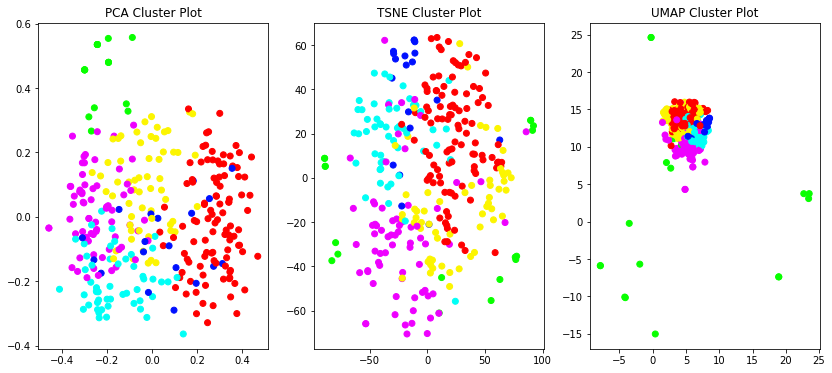

In [26]:
plot_tsne_pca_umap(embeddings, clusters_6)

## Build the Bertopic Model

In [27]:
# install dependencies
!pip install hdbscan
import hdbscan

In [28]:
# Define UMAP model to reduce embeddings dimension
umap_model = umap.UMAP(n_neighbors=100,
                       n_components=10,
                       min_dist=0.0,
                       metric='cosine',
                       random_state=42,
                       low_memory=True)

# Define HDBSCAN model to perform documents clustering
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=150,
                                min_samples=15,
                                metric='euclidean',
                                cluster_selection_method='eom',
                                prediction_data=True)

In [29]:
# Create BERTopic model
topic_model = BERTopic(top_n_words=10,
                       n_gram_range=(1,2), 
                       calculate_probabilities=True,
                       umap_model= umap_model,
                       hdbscan_model=hdbscan_model,
                       nr_topics='auto',
                       verbose=True)

# Train model, extract topics and probabilities
topics, probabilities = topic_model.fit_transform(data, embeddings)

In [30]:
# get topic frequency
topic_model.get_topic_freq().head()

,Topic,Count
0,-1,226060
1,0,109770
2,1,10115
3,2,2970
4,3,1976


In [31]:
# get topic model at position 5
topic_model.get_topic(5)

[('johnson', 0.2399721814523335),
 ('amp johnson', 0.13241323721228984),
 ('johnson amp', 0.1310657785506494),
 ('amp', 0.04874861048215952),
 ('single', 0.04161672044755777),
 ('single dose', 0.03647285601080312),
 ('johnson vaccine', 0.033514741395862115),
 ('the johnson', 0.029218000847280955),
 ('janssen', 0.02666871573621003),
 ('vaccine', 0.02596868789211748)]

In [32]:
# list all the topics
all_topics = topic_model.get_topics()
all_topics

{-1: [('the', 0.012088685964252218),
  ('and', 0.009608787026419938),
  ('be', 0.009297775970516444),
  ('have', 0.00855680076755349),
  ('you', 0.008530138853123995),
  ('get', 0.008385442494439089),
  ('for', 0.008158344238917507),
  ('vaccine', 0.007857400738786265),
  ('this', 0.007134174229023084),
  ('covid', 0.0070646057264112366)],
 0: [('the', 0.011114753043772707),
  ('and', 0.009447130298853402),
  ('get', 0.008798841083175484),
  ('vaccine', 0.008595269125637954),
  ('for', 0.008325395509161221),
  ('be', 0.008270148021979095),
  ('have', 0.008244582103017522),
  ('covid', 0.007814164054124339),
  ('you', 0.00760871419424222),
  ('this', 0.006639291992879653)],
 1: [('dose dose', 0.2695214105488552),
  ('dose', 0.22299867315041663),
  ('slot', 0.1795103789442061),
  ('slot dose', 0.13218579825066246),
  ('free slot', 0.12647537985867371),
  ('availability for', 0.12637966393549427),
  ('pay slot', 0.12625845926423068),
  ('availability', 0.12460544500863868),
  ('for free',

In [33]:
# get the information on all topics
info_df = topic_model.get_topic_info()
info_df

,Topic,Count,Name
0,-1,226060,-1_the_and_be_have
1,0,109770,0_the_and_get_vaccine
2,1,10115,1_dose dose_dose_slot_slot dose
3,2,2970,2_show slot_show_slot_locations show
4,3,1976,3_russia_sputnik_russian_putin
...,...,...,...
65,64,154,64_book invite_invite phone_via book_available jan
66,65,154,65_cbd_oil_cbd oil_gummies
67,66,154,66_trial_trials_the trials_the trial
68,67,151,67_lie_more lie_truth_liar


## Topic Visualization

In [34]:
topic_model.visualize_topics()

In [234]:
fig = topic_model.visualize_topics()
fig

In [35]:
topic_model.visualize_distribution(probabilities[20])

In [36]:
topic_model.visualize_barchart()

In [180]:
df['dated'] = pd.to_datetime(df['date'].str.strip(), errors='coerce')

In [181]:
def conv_dates_series(df, col, old_date_format, new_date_format):

    df[col] = pd.to_datetime(df[col], format=old_date_format).dt.strftime(new_date_format)
    
    return df

In [182]:
old_date_format='%Y-%m-%d'
new_date_format='%d/%m/%Y'

conv_dates_series(df, "dated", old_date_format, new_date_format)


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,dated
0,MyNewsNE,Assam,MyNewsNE a dedicated multi-lingual media house from North Eastern India.,24-05-2020 10:18,64.0,11.0,110.0,False,18-08-2020 12:55,Australia to Manufacture Covid-19 Vaccine and give it to the Citizens for free of cost: AFP quotes Prime Minister\n#CovidVaccine,['CovidVaccine'],Twitter Web App,False,18/08/2020
1,Shubham Gupta,NaN,I will tell about all experiences of my life from my videos hope that you all like the videos 🙂,14-08-2020 16:42,1.0,17.0,0.0,False,18-08-2020 12:55,#CoronavirusVaccine #CoronaVaccine #CovidVaccine Australia is doing very good https://t.co/kBT7l6pArY,"['CoronavirusVaccine', 'CoronaVaccine', 'CovidVaccine']",Twitter for Android,False,18/08/2020
2,Journal of Infectiology,NaN,Journal of Infectiology (ISSN 2689-9981) is accepting submissions for an upcoming Volume 3 Issue 2. For further queries contact editor@infectiologyjournal.com.,14-12-2017 07:07,143.0,566.0,8.0,False,18-08-2020 12:46,Deaths due to COVID-19 in Affected Countries\nRead More: https://t.co/V8Y3Stu0UW\n@r_piryani @shitalbhandary… https://t.co/6jpMxX2KtI,NaN,Twitter Web App,False,18/08/2020
3,Zane,NaN,Fresher than you.,18-09-2019 11:01,29.0,25.0,620.0,False,18-08-2020 12:45,@Team_Subhashree @subhashreesotwe @iamrajchoco Stay safe @subhashreesotwe di &amp; @iamrajchoco da ❤️❤️… https://t.co/ayhoaQm0Ls,NaN,Twitter for Android,False,18/08/2020
4,Ann-Maree O’Connor,"Adelaide, South Australia","Retired university administrator. Melburnian by birth, now living in Adelaide. Look back fondly to the Whitlam years; one of Keating’s true believers.",24-01-2013 14:53,83.0,497.0,10737.0,False,18-08-2020 12:45,@michellegrattan @ConversationEDU This is what passes for leadership in our country: a voucher for something that w… https://t.co/OUUb1PeYIj,NaN,Twitter Web App,False,18/08/2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368583,Bishesh News,NaN,Bishesh News is determined to provide truth & facts without Prejudice.,2021-06-28 15:20:45,125.0,0.0,1.0,False,2022-02-02 04:17:10,"A lady health worker carrying an aged lady on her back so that the lady can receive her Covid vaccine in Gulmi, Nepal.\n#Corona #Covid #CovidVaccine #Nepal #Gulmi #HealthWorkers #nurse\nPhoto: Humakant Pokhrel/RSS https://t.co/li1mmt2SRE","['Corona', 'Covid', 'CovidVaccine', 'Nepal', 'Gulmi', 'HealthWorkers', 'nurse']",Twitter for Android,False,02/02/2022
368584,@zhjea_klarity,"Pennsylvania, USA",WestPhillyGonza- TrapSaint\nFemale Rapper/Producer\nRoweHouseArtist Venue Live Events\nwgtctrade@hotmail.com inquiries,2016-05-21 21:57:00,117.0,315.0,1307.0,False,2022-02-02 04:16:04,"There's a million suicides this last 2 weeks, I hope it aint #COVID19 #covid #CovidVaccine 😳😳😳","['COVID19', 'covid', 'CovidVaccine']",Twitter for Android,False,02/02/2022
368585,Malpocada,NaN,I’m delightful,2010-12-29 05:53:05,3499.0,3773.0,22487.0,False,2022-02-02 04:09:13,"In my state, a 14 y/o can consent to sex with an 18 y/o, but can’t consent to a vaccine 🙄 #CovidVaccine #COVID19","['CovidVaccine', 'COVID19']",Twitter for iPhone,False,02/02/2022
368586,Señorita Risitas,NaN,NaN,2015-09-19 01:15:05,157.0,747.0,18031.0,False,2022-02-02 04:03:51,Fox News Silent After Guest Dies Of Covid\nhttps://t.co/bZAZ4XJMCG\n#COVID19 #antivaxx #antivaxxers #CovidVaccine #VaccinesWork #VaccinesSaveLives,"['COVID19', 'antivaxx', 'antivaxxers', 'CovidVaccine', 'VaccinesWork', 'VaccinesSaveLives']",Twitter for Android,False,02/02/2022


In [210]:
df['dated'] = df['dated'].fillna('02/02/2022')

In [211]:
timestamps = df['dated'].tolist()
timestamps[0:5]

['18/08/2020', '18/08/2020', '18/08/2020', '18/08/2020', '18/08/2020']

In [213]:
topics_over_time = topic_model.topics_over_time(data, 
                             topics=topics, 
                             timestamps=timestamps,
                             global_tuning=True, 
                             evolution_tuning=True,
                             nr_bins=20)

20it [14:12, 42.62s/it]


In [214]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20)

In [96]:
topic_model.get_representative_docs(topic=1)

['dose',
 'dose',
 'dose',
 'availability for free slot dose dose pay slot',
 'availability for free slot dose dose pay slot',
 'availability for free slot dose dose pay slot',
 'availability for free slot dose dose dose dose pay slot',
 'availability for free slot dose dose dose dose pay slot',
 'availability for free slot dose dose dose dose pay slot',
 'availability for free slot dose dose dose dose pay slot dose dose dose dose',
 'availability for free slot dose dose dose dose pay slot dose dose dose dose',
 'availability for free slot dose dose dose dose pay slot dose dose dose dose',
 'availability for free slot pay slot dose dose dose dose',
 'availability for free slot pay slot dose dose dose dose',
 'availability for free slot pay slot dose dose dose dose',
 'availability for free slot pay slot',
 'availability for free slot pay slot',
 'availability for free slot pay slot',
 'availability for free slot pay slot dose dose',
 'availability for free slot pay slot dose dose',
 'a

In [97]:
topic_model.get_representative_docs(topic=35)

['thank you', 'thank you', 'thank you']

In [98]:
topic_model.visualize_heatmap()

In [171]:
all_topics = topic_model.get_topics()
all_topics

{-1: [('the', 0.012088685964252218),
  ('and', 0.009608787026419938),
  ('be', 0.009297775970516444),
  ('have', 0.00855680076755349),
  ('you', 0.008530138853123995),
  ('get', 0.008385442494439089),
  ('for', 0.008158344238917507),
  ('vaccine', 0.007857400738786265),
  ('this', 0.007134174229023084),
  ('covid', 0.0070646057264112366)],
 0: [('the', 0.011114753043772707),
  ('and', 0.009447130298853402),
  ('get', 0.008798841083175484),
  ('vaccine', 0.008595269125637954),
  ('for', 0.008325395509161221),
  ('be', 0.008270148021979095),
  ('have', 0.008244582103017522),
  ('covid', 0.007814164054124339),
  ('you', 0.00760871419424222),
  ('this', 0.006639291992879653)],
 1: [('dose dose', 0.2695214105488552),
  ('dose', 0.22299867315041663),
  ('slot', 0.1795103789442061),
  ('slot dose', 0.13218579825066246),
  ('free slot', 0.12647537985867371),
  ('availability for', 0.12637966393549427),
  ('pay slot', 0.12625845926423068),
  ('availability', 0.12460544500863868),
  ('for free',

In [172]:
topic_model.visualize_hierarchy()